In [1]:
import os
import string
import h5py

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

import keras
from keras.optimizers import rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
from keras import backend as K
import glob
import shutil

import scipy.misc as misc
import scipy.ndimage as im

import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


In [2]:
!unzip ../data/augment.zip

Archive:  ../data/augment.zip
  inflating: augment/cow_1055527017_55e62eaf00.jpg  
  inflating: augment/cow_1095542741_52c57b1035.jpg  
  inflating: augment/cow_1360947429_035dc00685.jpg  
  inflating: augment/cow_1525154026_712c37f12d.jpg  
  inflating: augment/cow_156883111_ff65409697.jpg  
  inflating: augment/cow_161829865_2f00f0a262.jpg  
  inflating: augment/cow_169906742_e36141d3b9.jpg  
  inflating: augment/cow_199731620_69c4990b6a.jpg  
  inflating: augment/cow_2073779011_6e2f16fc61.jpg  
  inflating: augment/cow_2074591412_d6e529c385.jpg  
  inflating: augment/cow_2075368641_8f5d540048.jpg  
  inflating: augment/cow_2076053957_8fbb9665d5.jpg  
  inflating: augment/cow_2076055208_7f1918fb22.jpg  
  inflating: augment/cow_2076077885_d4a23cfc21.jpg  
  inflating: augment/cow_2076086447_8fbf036b3f.jpg  
  inflating: augment/cow_2076822002_63a7282e90.jpg  
  inflating: augment/cow_2076831636_403a38a2ef.jpg  
  inflating: augment/cow_2076838990_5468964248.jpg  
  inflating: augment

In [59]:
%mv augment ../data/
%mkdir ../data/augment/train
%mkdir ../data/augment/test

%mkdir ../data/augment/train/cow
%mkdir ../data/augment/train/giraffe
%mkdir ../data/augment/train/monkey

%mkdir ../data/augment/test/cow
%mkdir ../data/augment/test/giraffe
%mkdir ../data/augment/test/monkey


%mv ../data/augment/cow* ../data/augment/train/cow/
%mv ../data/augment/gir_cow* ../data/augment/train/giraffe/
%mv ../data/augment/mon* ../data/augment/train/monkey/

mv: augment: No such file or directory
mkdir: ../data/augment/train: File exists
mkdir: ../data/augment/test: File exists
mkdir: ../data/augment/train/cow: File exists
mkdir: ../data/augment/train/giraffe: File exists
mkdir: ../data/augment/train/monkey: File exists
mv: rename ../data/augment/cow* to ../data/augment/train/cow/cow*: No such file or directory
mv: rename ../data/augment/gir_cow* to ../data/augment/train/giraffe/gir_cow*: No such file or directory
mv: rename ../data/augment/mon* to ../data/augment/train/monkey/mon*: No such file or directory


In [53]:
def show(img):
    plt.figure()
    plt.imshow(img, cmap='gray')
    
    
def scale(img):
    return img.astype('float64') * 1.0/ float(img.max())
    
def convolve(img, n, thresh):
    k = np.ones((3,3))
    k[1,1] = 2.0
    
    for _ in xrange(n):
        img[img > thresh] = 1.0
        img[img < thresh] = 0.0
        img = scale(im.convolve(img, k, mode='constant', cval=1.0))

    return img

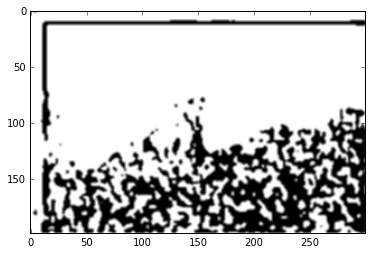

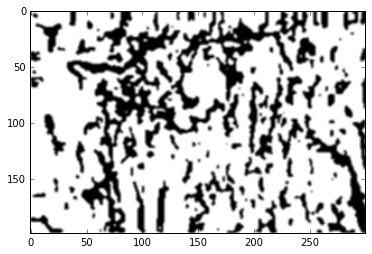

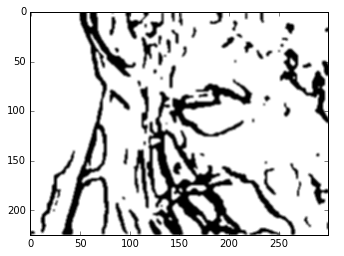

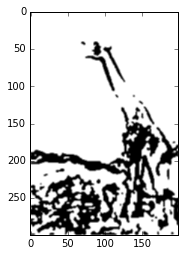

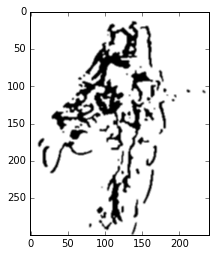

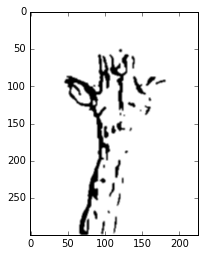

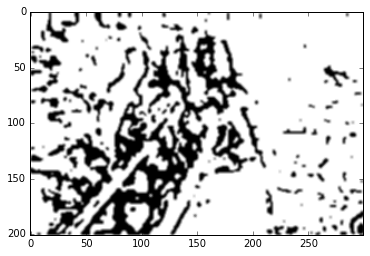

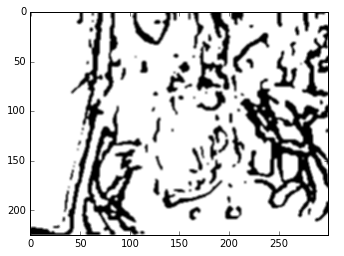

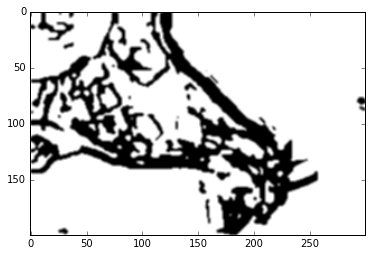

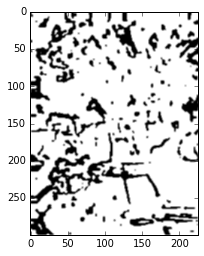

In [71]:
cows = glob.glob('../data/augment/train/giraffe/*')
for i in xrange(10):
    img = im.imread(cows[i], flatten=True)
    img = scale(img)
    img = convolve(img, 4, 0.5)
    show(img)

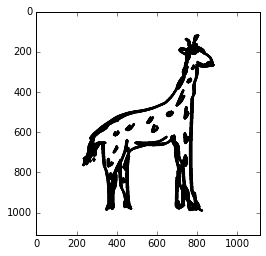

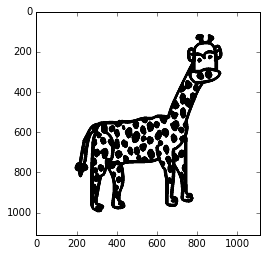

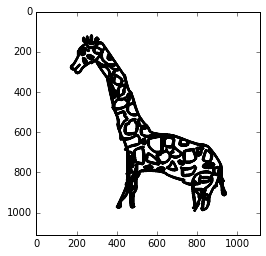

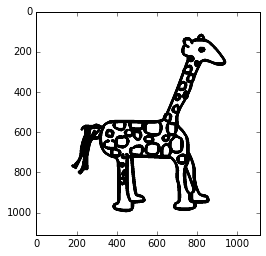

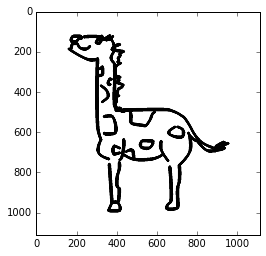

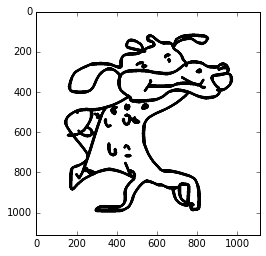

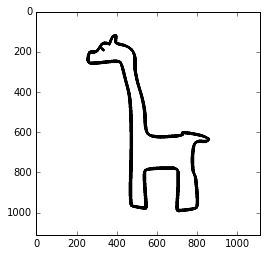

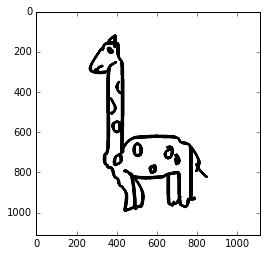

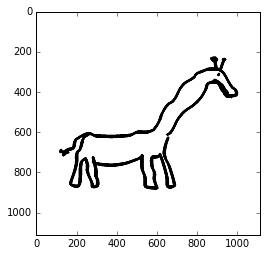

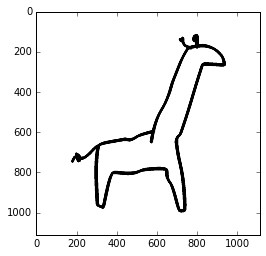

In [64]:
cows = glob.glob('../data/tu-berlin/train/giraffe/*')
for i in xrange(10):
    img = im.imread(cows[i], flatten=True)
    img = scale(img)
    img = convolve(img, 8, 0.8)
    show(img)

In [68]:
# make a combined dataset:

%mkdir ../data/combined
%mkdir ../data/combined/train
%mkdir ../data/combined/test

%mkdir ../data/combined/train/cow
%mkdir ../data/combined/train/giraffe
%mkdir ../data/combined/train/monkey


%mkdir ../data/combined/test/cow
%mkdir ../data/combined/test/giraffe
%mkdir ../data/combined/test/monkey

In [3]:
classes = ['cow', 'monkey', 'giraffe']

In [69]:
# for each in augmented filter and move
for clas in classes:
    files = glob.glob('../data/augment/train/'+clas+'/*')
    for i, filen in enumerate(files):
        img = im.imread(filen, flatten=True)
        img = scale(img)
        img = convolve(img, 4, 0.5)
        misc.imsave('../data/combined/train/'+clas+'/'+clas+'_augmented_'+str(i)+'.png', img)

In [70]:
for clas in classes:
    files = glob.glob('../data/tu-berlin/train/'+clas+'/*')
    for i, filen in enumerate(files):
        img = im.imread(filen, flatten=True)
        img = scale(img)
        img = convolve(img, 8, 0.8)
        misc.imsave('../data/combined/train/'+clas+'/'+clas+str(i)+'.png', img)
        
    test = glob.glob('../data/tu-berlin/test/'+clas+'/*')
    for i, filen in enumerate(test):
        img = im.imread(filen, flatten=True)
        img = scale(img)
        img = convolve(img, 8, 0.8)
        misc.imsave('../data/combined/test/'+clas+'/'+clas+str(i)+'.png', img)
        

In [4]:
# set up reference
%mkdir ../data/combined/reference
%mkdir ../data/combined/reference/train
%mkdir ../data/combined/reference/test


for clas in classes:
    %cp -r ../data/tu-berlin/train/{clas} ../data/combined/reference/train/{clas}
    %cp -r ../data/tu-berlin/test/{clas} ../data/combined/reference/test/{clas}



mkdir: ../data/combined/reference: File exists
mkdir: ../data/combined/reference/train: File exists
mkdir: ../data/combined/reference/test: File exists
